Package
======

In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cuda


In [3]:
EPOCH = 30
BATCH_SIZE = 100
NUM_WORKERS = 2
learning_rate = 0.005

In [4]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.CIFAR10(
    root      = './.data/',
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.CIFAR10(
    root      = './.data/',
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential( # nn.Sequential을 사용해 encoder와 decoder 두 모듈로 묶어줍니다.
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, padding_mode='zeros'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

        )
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 latent vector를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [7]:
summary_(autoencoder.encoder, (3,32,32), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 16, 32, 32]             448
              ReLU-2          [100, 16, 32, 32]               0
         MaxPool2d-3          [100, 16, 16, 16]               0
            Conv2d-4          [100, 32, 16, 16]           4,640
              ReLU-5          [100, 32, 16, 16]               0
         MaxPool2d-6            [100, 32, 8, 8]               0
            Conv2d-7            [100, 32, 8, 8]           9,248
              ReLU-8            [100, 32, 8, 8]               0
         MaxPool2d-9            [100, 32, 4, 4]               0
Total params: 14,336
Trainable params: 14,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.17
Forward/backward pass size (MB): 45.70
Params size (MB): 0.05
Estimated Total Size (MB): 46.93
-------------------------------------------

In [8]:
summary_(autoencoder.decoder, (32,4,4), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [100, 32, 8, 8]           4,128
              ReLU-2            [100, 32, 8, 8]               0
   ConvTranspose2d-3          [100, 16, 16, 16]           2,064
              ReLU-4          [100, 16, 16, 16]               0
   ConvTranspose2d-5           [100, 3, 32, 32]             195
              ReLU-6           [100, 3, 32, 32]               0
Total params: 6,387
Trainable params: 6,387
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.20
Forward/backward pass size (MB): 14.06
Params size (MB): 0.02
Estimated Total Size (MB): 14.28
----------------------------------------------------------------


In [9]:
view_data = testset.data[:10]
print(view_data.shape)
view_data = np.transpose(view_data,(0,3,1,2))
print(view_data.shape)
view_data = torch.tensor(view_data)
view_data = view_data.type(torch.FloatTensor)/255.

(10, 32, 32, 3)
(10, 3, 32, 32)


In [10]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    total_loss=0
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 3, 32, 32).to(DEVICE)
        y = x.view(-1, 3, 32, 32).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))

    return total_loss

In [11]:
def test(autoencoder, test_loader):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 3, 32, 32).to(DEVICE)
        y = x.view(-1, 3, 32, 32).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss


    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))

    return total_loss

In [12]:
train_losses=[]
test_losses=[]
#학습하기
for epoch in range(1, EPOCH+1):
    loss_epoch = train(autoencoder, train_loader)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader)
    test_losses.append(loss_epoch)
    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    print("[Epoch {}]".format(epoch))


total train loss:10.35484790802002
total test loss:1.225557565689087
[Epoch 1]
total train loss:5.669760227203369
total test loss:1.0524693727493286
[Epoch 2]
total train loss:5.16528844833374
total test loss:1.023544430732727
[Epoch 3]
total train loss:4.903531551361084
total test loss:0.9592103362083435
[Epoch 4]
total train loss:4.728041648864746
total test loss:0.913831889629364
[Epoch 5]
total train loss:4.582067966461182
total test loss:0.8924503326416016
[Epoch 6]
total train loss:4.350403308868408
total test loss:0.86122727394104
[Epoch 7]
total train loss:4.212668418884277
total test loss:0.8269397020339966
[Epoch 8]
total train loss:4.148087024688721
total test loss:0.8067678213119507
[Epoch 9]
total train loss:4.09751558303833
total test loss:0.798702597618103
[Epoch 10]
total train loss:4.038583278656006
total test loss:0.7963980436325073
[Epoch 11]
total train loss:4.0132880210876465
total test loss:0.789715588092804
[Epoch 12]
total train loss:3.9717519283294678
total tes

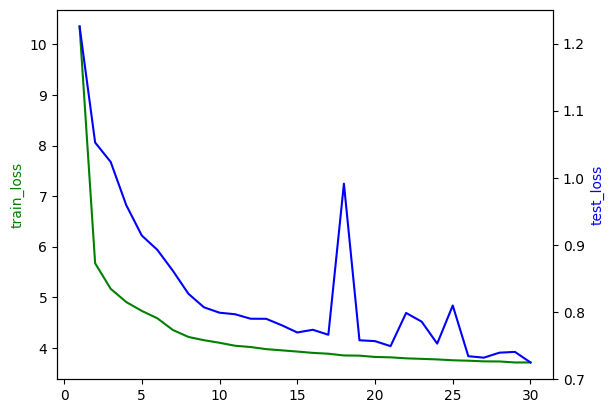

In [13]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()


In [14]:
idx = 915
view_data = testset.data[idx]
print(view_data.shape)
view_data = np.transpose(view_data,(2,0,1))
print(view_data.shape)
view_data = torch.tensor(view_data)
view_data = view_data.type(torch.FloatTensor)/255.
view_data = view_data.to(DEVICE)
_, decoded_data = autoencoder(view_data)
decoded_data = decoded_data.to("cpu")
out = decoded_data.detach().numpy()
out = np.transpose(out,(1,2,0))
out = out*255
final_out = out.astype(np.uint8)
PIL_image1 = Image.fromarray(np.uint8(testset.data[idx])).convert('RGB')
PIL_image2 = Image.fromarray(np.uint8(final_out)).convert('RGB')


(32, 32, 3)
(3, 32, 32)


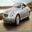

In [15]:
PIL_image1

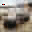

In [16]:
PIL_image2